In [1]:
from egnn import EGNN

In [2]:
import numpy as np
import pandas as pd

import os
import math

from tqdm import tqdm
import wandb

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, Beta, Uniform
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

import torch_geometric as tg
from torch_geometric.data import Data, Batch
# from torch_geometric.loader import DataLoader
from torch_geometric.nn import aggr

from torch_scatter import scatter_add, scatter_mean
from schnet import SchNet

from itertools import combinations, permutations, product


import matplotlib.pyplot as plt

In [3]:
PI = math.pi

In [4]:
l_uc = torch.tensor([18.256,20.534,7.5420])
n_l = torch.tensor([2,2,4])
l_sc = l_uc*n_l

In [5]:
def difference(X1, X2):
    diff = (X2[:,None] - X1)
    diff = torch.where(diff>.5, diff-1, diff)
    diff = torch.where(diff<-.5, diff+1, diff)
    return diff

def distance(X1, X2, l):
    # X1 = X1/l
    # X2 = X2/l
    diff = difference(X1, X2)
    diff *= l
    dist = diff.pow(2).sum(-1).pow(0.5)
    return dist
    
def _lj(sigma, epsilon, r):
    return 4*epsilon*((sigma/r)**12 - (sigma/r)**6)

def lj(X1, X2, epsilon, sigma, l_sc):
    dist = distance(X1, X2, l_sc)
    e = torch.where(dist<=12, _lj(sigma, epsilon, dist), 0)
    return e

def get_energy(X_n, X_c, X_o, l_sc, n_l=None, uc=False):

    if uc:
        uc_idx = np.array(list(product(*[range(i) for i in n_l])))

        X_o = torch.cat([X_o+idx for idx in uc_idx], 0)/n_l
        X_n = torch.cat([X_n+idx for idx in uc_idx], 1)/n_l
        X_c = X_c/n_l

    assert X_c.shape[0] == X_n.shape[0]
    n = X_c.shape[0]

    e = torch.zeros((n,))

    for i in range(n):
        e_oc = lj(X_o, X_c[i,None], 115, 3.47, l_sc).sum()
        e_no = lj(X_o, X_n[i], 23, 3.4, l_sc).sum()
        e_nc = lj(X_n[i], X_c[i,None], 553.061, 2.176, l_sc).sum()
        e[i] = e_oc + e_no + e_nc
        
    return e

In [6]:
def get_co2(file, l=l_sc):
    with open(file, 'r') as f:
        lines = f.readlines()
    coordinates = []

    for line in lines:
        if line.startswith('ATOM'):
            parts = line.split()
            if parts[2] == 'C':
                x_coord, y_coord, z_coord = map(float, parts[4:7])
                coordinates.append((x_coord, y_coord, z_coord))
    coordinates = torch.tensor(coordinates)
    # coordinates = torch.remainder(coordinates, l)
    
    coordinates /= l
    return coordinates

In [7]:
def get_atoms(file, get_o=False):

    with open(file) as f:
        lines = f.readlines()
    lines = [i.strip().split() for i in lines]
    lines = [i for i in lines if len(i)>1]


    at_pos = [i[1:5] for i in lines if i[1] in ['Si', 'Al']]
    atom = np.array([1 if i[0]=='Al' else 0 for i in at_pos])
    X = np.array([list(map(float, i[1:])) for i in at_pos])

    if not get_o:
        return torch.tensor(atom), torch.tensor(X)    
    else:
        o_pos = [i[1:5] for i in lines if i[1] == 'O']
        X_o = np.array([list(map(float, i[1:])) for i in o_pos])
        return torch.tensor(atom), torch.tensor(X), torch.tensor(X_o)

In [8]:
def get_na(file, l=l_sc):
    with open(file, 'r') as f:
        lines = f.readlines()
    cnt = 0
    
    coordinates = torch.zeros((0,3))
    batch = torch.zeros((0,), dtype=int)
    
    for line in lines:
        if line.startswith("CRYST"):
            
            _coords = []
            
        elif line.startswith("ATOM"):
            
            parts = line.split()
            x_coord, y_coord, z_coord = map(float, parts[4:7])
            _coords.append((x_coord, y_coord, z_coord))
            
        elif line.startswith("ENDMDL"):
            coords = torch.tensor(_coords)
            coordinates = torch.cat([coordinates, coords], 0)
            
            batch = torch.cat([batch, torch.tensor(len(coords)*[cnt])])
            cnt+=1
    
    coordinates /= l

    
    return coordinates#, batch

In [9]:
class EdgeData(Data):
    def __inc__(self, key, value, *args, **kwargs):
        if 'edge_index' in key:
            return len(self.x)
        return super().__inc__(key, value, *args, **kwargs)

In [10]:
ats, X, X_o  = get_atoms(f'data/co2_cifs/MOR_500.cif', True)
X_c = get_co2(f'data/co2/CO2_500.pdb')
X_n = get_na(f'data/na/Na_500.pdb').reshape(1500,-1,3)
# X_co2 = torch.remainder(X_co2, 1/n_l)*n_l
# X_co2 *= l_uc


In [11]:
X_n.reshape(1500, -1, 3).shape, X_c.shape, X_o.shape

(torch.Size([1500, 64, 3]), torch.Size([1500, 3]), torch.Size([96, 3]))

In [12]:
e = get_energy(X_n, X_c, X_o/n_l, l_sc)

In [13]:
e.mean()

tensor(-148.1233)

In [14]:
d = distance(X_n, X_c[:,None], l_sc)

In [15]:
X_n.shape, X_c.shape

(torch.Size([1500, 64, 3]), torch.Size([1500, 3]))

In [16]:
X_c.shape, X_n.shape, X_o.shape

(torch.Size([1500, 3]), torch.Size([1500, 64, 3]), torch.Size([96, 3]))

In [17]:
e_oc.shape, e_no.shape, e_nc.shape

NameError: name 'e_oc' is not defined

In [18]:
e_oc.shape

NameError: name 'e_oc' is not defined

In [19]:
d.shape

torch.Size([1500, 1500, 64])

In [20]:
def difference(X1, X2):
    diff = (X2[:,None] - X1)
    diff = torch.where(diff>.5, diff-1, diff)
    diff = torch.where(diff<-.5, diff+1, diff)
    return diff

def distance(X1, X2, l):
    # X1 = X1/l
    # X2 = X2/l
    diff = difference(X1, X2)
    diff *= l
    dist = diff.pow(2).sum(-1).pow(0.5)
    return dist

In [21]:
# idxes = range(5,35)

# lst = [get_atoms(f'data/co2_cifs/MOR_{i}.cif') for i in idxes]
# lst = [i[0] for i in lst]
# lst

In [22]:
X_na = get_na('data/na/Na_100.pdb', l_sc)
X_co2 = get_co2('data/co2/CO2_100.pdb')
atoms, X = get_atoms('data/co2_cifs/MOR_100.cif')

In [23]:
X_na.max(), X_co2.max(), X.max()

(tensor(1.), tensor(0.9999), tensor(0.9570, dtype=torch.float64))

In [24]:
# get_co2_na(atoms, X_co2, X_na, l_sc, 1500)

In [25]:
def get_co2_na(atoms, pos_co2, pos_na, l_sc, n_l, n_samples):
    _co2 = pos_co2.reshape(n_samples, 1, 3)
    _na = pos_na.reshape(n_samples,-1,3)
    diff = (_co2 - _na).abs()
    diff = torch.where(diff>0.5, diff-1, diff)
    dist = (diff*l_sc).pow(2).sum(-1).pow(0.5)

    selected = dist.argsort(dim=1)[:,:sum(atoms)]

    na = _na[torch.arange(n_samples).unsqueeze(1), selected, :]
    na = torch.remainder(na, 1/n_l)*n_l
    co2 = torch.remainder(_co2, 1/n_l)*n_l

    return na, co2
    # print(co2.shape, na.shape, co2.max(), na.max())

In [26]:
class ZeoDataset(Dataset):

    def __init__(self, zeo_idxes, l_uc, l_sc, n_l, cutoff=6.5, n_samples=1500):

        self.n_samples = n_samples
        self.l_uc = l_uc
        self.cutoff = cutoff
        

        self.ats_zeo = []
        self.pos_zeo = []
        self.pos_na = []
        self.pos_co2 = []
        
        for idx in tqdm(zeo_idxes):
            ats_z, pos_z = get_atoms(f'data/co2_cifs/MOR_{idx}.cif')
            # self.ats_zeo, self.pos_zeo = list(zip(*atpos))#  [i[0] for i in atpos]
        # self.pos_zeo = [i[1] for i in atpos]
            _pos_n = get_na(f'data/na/Na_{idx}.pdb', l_sc)
            _pos_c = get_co2(f'data/co2/CO2_{idx}.pdb', l_sc)
            pos_n, pos_c = get_co2_na(ats_z, _pos_c, _pos_n, l_sc, n_l, n_samples)

            self.ats_zeo.append(ats_z)
            self.pos_zeo.append(pos_z)
            self.pos_na.append(pos_n)
            self.pos_co2.append(pos_c)
            # self.pos_na, self.pos_co2 = list(zip(*pos_nac))
        
    def __len__(self):
        return len(self.ats_zeo)*self.n_samples
    
    def __getitem__(self, idx):

        zeo_idx = idx // 1500
        na_idx = idx % 1500

        ats_zeo = self.ats_zeo[zeo_idx]
        pos_zeo = self.pos_zeo[zeo_idx]
        pos_na = self.pos_na[zeo_idx][na_idx]
        pos_co2 = self.pos_co2[zeo_idx][na_idx]

        assert sum(ats_zeo) == pos_na.shape[0], "different amount of Al and Na atoms!"

        ats = F.one_hot(torch.cat([ats_zeo, torch.tensor(sum(ats_zeo)*[2] + [3])]))

        num_ats = len(pos_zeo)+sum(ats_zeo)+1
        
        
        pos_nac = torch.cat([pos_na, pos_co2],0)
        pos = torch.cat([pos_zeo, pos_nac], 0)

        d = distance(pos, pos, l_uc).fill_diagonal_(np.inf)

        idx1, idx2 = torch.where(d<self.cutoff)
        _edge_index = torch.vstack([idx1, idx2])

        mask1 = (_edge_index >= len(pos_zeo)).all(0) # edges  na/c
        mask2 = ~(_edge_index >= len(pos_zeo)).any(0) # edges between al/si

        mask = torch.logical_or(mask1, mask2)


        
        edge_index = _edge_index[:,mask2] # edges between zeolite atoms

        edge_index_nac = _edge_index[:,mask1] # edges between na/co2
        
        edge_index_nac_zeo = _edge_index[:,~mask] # edges from na/co2 to zeo atoms (and vice versa)

        
        graph = EdgeData(x=ats,
                         edge_index=edge_index,
                         edge_index_nac=edge_index_nac,
                         edge_index_nac_zeo=edge_index_nac_zeo,
                         pos=pos*l_uc) # transform to cartesian coordinates
        return graph

def collate_fn(batch):

    return Batch.from_data_list(batch)

In [27]:
# trainloader = DataLoader(trainset, 10, collate_fn=collate_fn)

In [28]:
# a = torch.tensor([0,0,0])
# torch.vstack([a for _ in range(5)]).shape

In [29]:
def create_zeo(atoms, pos, l_uc, cutoff=6.5):

    n_al = sum(atoms)

    ats = F.one_hot(torch.cat([torch.tensor(atoms), torch.tensor(sum(atoms)*[2] + [3])]))

    zero = torch.tensor([0.,0.,0.])
    pos_nac = torch.vstack([zero for _ in range(n_al+1)])

    pos = torch.cat([pos,pos_nac],0)
    
    dist = distance(pos, pos, l_uc.cpu())
    dist = dist.fill_diagonal_(np.inf)
    dist[n_al+1:] = np.inf
    dist[:,n_al+1:] = np.inf
    
    idx1, idx2 = torch.where(dist<cutoff)
    edge_index = torch.vstack([idx1, idx2])

    graph = EdgeData(x=ats, pos=pos*l_uc.cpu(), edge_index=edge_index)
    return graph

def calculate_nac_zeo_edges(atoms, pos, batch, l_uc, cutoff=8.5):

    pos = pos/l_uc
    at_mask = atoms.argmax(1) > 1
    idx = torch.arange(len(pos)).to(pos.device)
    # pos_nac = atoms[at_mask]

    new_edge = []
    for i in range(len(batch.unique())):
        mask = batch == i
        
        _at_mask = at_mask[mask]
        _idx = idx[mask]
        _pos = pos[mask]
        
        _pos_nac = _pos[_at_mask]
        _pos_zeo = _pos[~_at_mask]
        _idx_nac = _idx[_at_mask]
        _idx_zeo = _idx[~_at_mask]

        # edges between zeolite and Na/C
        iidx = _idx_zeo[:, None].repeat(1,len(_idx_nac))
        jidx = _idx_nac[None].repeat(len(_idx_zeo),1)
        
        dist_mask = distance(_pos_nac, _pos_zeo, l_uc)<cutoff
        
        iidx, jidx = iidx[dist_mask], jidx[dist_mask]
        
        ij, ji = torch.vstack((iidx, jidx)), torch.vstack((jidx, iidx))
        new_edge.extend([ij,ji])

        # edges betwen Na/C
        dist_mask2 = distance(_pos_nac, _pos_nac, l_uc).fill_diagonal_(np.inf) < cutoff

        iidx2 = _idx_nac[:, None].repeat(1,len(_idx_nac))
        jidx2 = _idx_nac[None].repeat(len(_idx_nac),1)
        
        iidx2, jidx2 = iidx2[dist_mask2], jidx2[dist_mask2]
        
        ij2, ji2 = torch.vstack((iidx2, jidx2)), torch.vstack((jidx2, iidx2))
        new_edge.extend([ij2,ji2])
        
        
    
        
    return torch.cat(new_edge, 1)


In [30]:
def get_idxes(idx_min, idx_max):
    # drop indices which we do not have data for in the given range
    idxes = [idx for idx in range(idx_min, idx_max) if os.path.isfile(f'data/co2/CO2_{idx}.pdb')]
    return idxes        
    

In [31]:
train_idxes = get_idxes(211, 212)
test_idxes = get_idxes(211, 212)
trainset = ZeoDataset(train_idxes, l_uc, l_sc, n_l)
testset = ZeoDataset(test_idxes, l_uc, l_sc, n_l)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


In [42]:
class Encoder(nn.Module):

    def __init__(self, l_uc, hidden_size=32, latent_size=32):
        super().__init__()

        self.l = nn.Parameter(l_uc, requires_grad=False)
        self.gnn = EGNN(4, hidden_size, latent_size, l=l_uc, device='cuda', normalize=True, tanh=True)
        self.aggr = aggr.MeanAggregation()
        
        self.z_mu = nn.Linear(latent_size, latent_size)
        self.z_sigma = nn.Linear(latent_size, latent_size)


    def forward(self, x, pos, edge_index, batch, num_nodes):

        h, _ = self.gnn(x, pos, edge_index, None, num_nodes)
        h = self.aggr(h, batch)
        mu = self.z_mu(h)
        sigma = F.softplus(self.z_sigma(h))

        return mu, sigma
        
class Decoder(nn.Module):

    def __init__(self, l_uc, hidden_size=32, latent_size=32):
        super().__init__()
        
        self.l = nn.Parameter(l_uc, requires_grad=False)
        self.gnn = EGNN(hidden_size, hidden_size, 1, l=l_uc, device='cuda', predict_force=True, normalize=True, tanh=True, z_size=latent_size)

        self.emb = nn.Linear(latent_size+4, hidden_size)

    
    def forward(self, x, z, pos, edge_index, batch, num_nodes):

        z = torch.index_select(z, 0, batch)
        h = torch.cat([x,z], -1)
        h = self.emb(h)

        mask = x.argmax(1) > 1 # mask for crystal atoms
        
        _, coords, F_st = self.gnn(h, pos, edge_index, None, num_nodes, mask, z)
        
        # diff = no noise - yes noise

        diff = coords - pos
        diff = torch.where(diff > 0.5*self.l, diff-self.l, diff)
        diff = torch.where(diff < -0.5*self.l, diff+self.l, diff)
        return diff
        
        # s, t = edge_index
        
        # diff = coords[t] - coords[s]
        # diff = torch.where(diff > 0.5*self.l, diff-self.l, diff)
        # diff = torch.where(diff < -0.5*self.l, diff+self.l, diff)
        # dist = diff.pow(2).sum(-1).pow(0.5)[:,None]

        # V_st = diff/dist
        # F_st_vec = F_st[:,:,None]*V_st[:,None,:]
        # F_t = scatter_add(F_st_vec, t, dim=0, dim_size=num_nodes).squeeze(1)

        
        # return F_t

        


class VAE(nn.Module):

    def __init__(self, l_uc, hidden_size=32, latent_size=32, sigma_1=10, sigma_2=0.01, noise_level=50):
        super().__init__()


        self.l = nn.Parameter(l_uc, requires_grad=False)
        self.encoder = Encoder(l_uc, hidden_size, latent_size)
        self.decoder = Decoder(l_uc, hidden_size, latent_size)

        self.z = latent_size


        sigmas = torch.tensor(np.exp(np.linspace(
            np.log(sigma_1),
            np.log(sigma_2),
            noise_level)), dtype=torch.float32)

        self.sigmas = nn.Parameter(sigmas, requires_grad=False)
        
    def forward(self, x, pos, edge_index_zeo, edge_index_nac, edge_index_nac_zeo, batch, num_nodes):
        
        edge_index = torch.cat([edge_index_zeo,edge_index_nac,edge_index_nac_zeo], 1)
        

        mu, sigma = self.encoder(x, pos, edge_index, batch, num_nodes)
        dist = Normal(mu, sigma+1e-6)
        z = dist.rsample()

        # add noise here
        # stuff with sigmas etc
        mask = x.argmax(1) > 1

        nac = pos[mask]
        # plt.hist2d(nac[:,0].detach().cpu(),nac[:,1].detach().cpu())
        nac_org = nac.clone()
        nac_batch = batch[mask]

        _, num_atoms = torch.unique(nac_batch, return_counts=True)
        
        noise_level = torch.randint(0, self.sigmas.size(0),
                                    (num_atoms.size(0),),
                                    device=self.sigmas.device)
        used_sigmas_per_atom = self.sigmas[noise_level].repeat_interleave(
            num_atoms, dim=0)

        nac = nac + torch.randn_like(nac)*used_sigmas_per_atom[:,None]
        nac_noise = torch.remainder(nac, self.l)
        
        # plt.hist2d(nac_noise[:,0].detach().cpu(),nac_noise[:,1].detach().cpu())
        
        
        pos[mask] = nac_noise
        
        edge_index_nac_zeo = calculate_nac_zeo_edges(x, pos, batch, self.l)

        edge_index = torch.cat([edge_index_zeo, edge_index_nac_zeo], 1)

        coord_diff = self.decoder(x, z, pos, edge_index, batch, num_nodes)[mask]

        return coord_diff, nac_org, nac_noise, nac_batch, used_sigmas_per_atom, z, dist # other things??

    

    @torch.no_grad()
    def langevin_dynamics(self, z, ld_kwargs, x, pos, edge_index_zeo, batch, num_nodes, save_traj=False, pbar=False):

        pos_list = []
        # fig, ax = plt.subplots(2)
        mask = x.argmax(1) > 1
        pos[mask] = torch.rand_like(pos[mask])*self.l
        edge_index_nac_zeo = calculate_nac_zeo_edges(x, pos, batch, self.l)
        edge_index = torch.cat([edge_index_zeo, edge_index_nac_zeo], 1)

        # ax[0].hist2d(pos[:, 0].cpu(), pos[:, 1].cpu(), bins=100)
        loop = tqdm(self.sigmas) if pbar else self.sigmas
        # lala = 0
        for sigma in loop:

            if sigma < ld_kwargs['min_sigma']:
                break
            step_size = ld_kwargs['step_lr'] * (sigma / self.sigmas[-1]) ** 2

            for step in range(ld_kwargs['n_step_each']):
                # lala+= 1
                noise_cart = torch.randn_like(pos[mask]) * torch.sqrt(step_size * 2)
                coord_diff = self.decoder(x, z, pos, edge_index, batch, num_nodes)[mask]
                coord_diff = coord_diff/sigma

                new_pos = pos[mask] + step_size*coord_diff + noise_cart
                new_pos = torch.remainder(new_pos, self.l)
                pos[mask] = new_pos
                # if lala == 1:
                #     ax[1].hist2d(pos[:, 0].cpu(), pos[:, 1].cpu(), bins=100)
        
                if save_traj:
                    pos_list.append(pos.cpu().numpy())
        return pos, pos_list
        
    def rec_loss(self, coord_diff, nac_noise, nac_org, used_sigmas, nac_batch):

        diff = nac_org - nac_noise
        diff = torch.where(diff > 0.5*self.l, diff-self.l, diff)
        diff = torch.where(diff < -0.5*self.l, diff+self.l, diff)

        diff = diff#/used_sigmas[:,None]
        coord_diff = coord_diff#/used_sigmas[:,None]

        d_diff = diff - coord_diff
        d_diff  = torch.where(d_diff > 0.5*self.l, d_diff-self.l, d_diff)
        d_diff = torch.where(d_diff < -0.5*self.l, d_diff+self.l, d_diff)
        
        loss_per_atom = torch.sum((d_diff/used_sigmas[:,None])**2,dim=1)
        loss = scatter_mean(loss_per_atom, nac_batch).mean()
        return loss


    def kld_loss(self, posterior, z):

        mu = torch.zeros_like(z)
        sigma = torch.ones_like(z)
        prior = Normal(mu, sigma)


        kld = (posterior.log_prob(z)-prior.log_prob(z)).sum(1).mean()

        return kld

    def training_step(self, databatch, beta, opt):
        # (x,
        #  pos,
        #  edge_index,
        #  edge_index_nac,
        #  edge_index_nac_zeo,
        #  batch,
        #  num_nodes) = unpack_batch(databatch)
        opt.zero_grad()
        data = unpack_batch(databatch)
        coord_diff, nac_org, nac_noise, nac_batch, used_sigmas, z, dist = self.forward(*data)

        rec_loss = self.rec_loss(coord_diff, nac_noise, nac_org, used_sigmas, nac_batch)
        kld_loss = self.kld_loss(dist, z)

        
        loss = rec_loss + beta*kld_loss
        log_dict = {'kl':kld_loss.item(), 'rec':rec_loss.item(), 'loss':loss.item()}
        loss.backward()
        opt.step()
        return log_dict
        
    def sample(self, atoms, pos, n_samples, ld_kwargs, save_traj=False):

        graphs = [create_zeo(atoms, pos, self.l) for i in range(n_samples)]
        data = Batch.from_data_list(graphs)

        x = data.x.float().to('cuda')
        pos = data.pos.float().to('cuda')
        edge_index = data.edge_index.to('cuda')
        batch = data.batch.to('cuda')
        num_nodes = data.num_nodes

        x, pos, pos_list = self._sample(x, pos, edge_index, batch, num_nodes, ld_kwargs, None, save_traj)
        return x, pos, pos_list
    
    def _sample(self, x, pos, edge_index, batch, num_nodes, ld_kwargs, z=None, save_traj=False):
        n_samples = len(torch.unique(batch))
        if z is None:
            z = torch.randn((n_samples, self.z), device=x.device)#Normal(torch.zeros((self.z)), torch.ones((self.z))).rsample([n_samples]).to(x.device)
        else:
            assert z.shape[0] == n_samples, "Amount of samples and structures must be equal!"

        pos, pos_list = self.langevin_dynamics(z, ld_kwargs, x, pos, edge_index, batch, num_nodes, save_traj)

        return x, pos, pos_list
        
        
def unpack_batch(databatch, device='cuda'):
    x = databatch.x.float().to(device)
    pos = databatch.pos.float().to(device)
    edge_index = databatch.edge_index.to(device)
    edge_index_nac = databatch.edge_index_nac.to(device)
    edge_index_nac_zeo = databatch.edge_index_nac_zeo.to(device)
    batch = databatch.batch.to(device)
    num_nodes = databatch.num_nodes
    return x, pos, edge_index, edge_index_nac, edge_index_nac_zeo, batch, num_nodes


def get_sample(idx, ld_kwargs, n_samples=50):
    ats, X, X_o  = get_atoms(f'data/co2_cifs/MOR_{idx}.cif', True)
    uc_idx = np.array(list(product(*[range(i) for i in n_l])))

    _X_o = torch.cat([X_o+idx for idx in uc_idx], 0)/n_l
    X_co2 = get_co2(f'data/co2/CO2_{idx}.pdb')
    X_na = get_na(f'data/na/Na_{idx}.pdb').reshape(1500, -1, 3)
    
    e_true = get_energy(X_na, X_co2, _X_o, l_sc)
    
    
    X_co2 = torch.remainder(X_co2, 1/n_l)*n_l
    X_co2 *= l_uc

    
    ats2 = torch.cat([ats, torch.tensor([2]*len(X_co2))])
    
    ats = ats.numpy()
    ats, pos, pos_list = vae.sample(ats, X, n_samples, ld_kwargs)
    mask = ats.argmax(1) != 2
    poss = pos[mask]
    atss = ats[mask]

    X_n = pos[~mask].reshape(n_samples, -1, 3).cpu()/l_uc
    X_c = pos[ats.argmax(1) == 3].cpu()/l_uc

    e_pred = get_energy(X_n, X_c, X_o, l_sc, n_l, uc=True)
    
    fig, ax = plt.subplots(ncols=3, figsize=(18,6))
    ax[0].scatter(poss[:,0].cpu(), poss[:,1].cpu(), c=atss.argmax(1).cpu())
    ax[0].set_title(f'Generated Samples')

    ax[1].scatter(pos[:,0].cpu(), pos[:,1].cpu(), c=ats.argmax(1).cpu())
    ax[1].set_title(f'Generated Samples with Na')
    
    X *= l_uc

    X2 = torch.cat([X, X_co2])
    
    
    ax[2].scatter(X2[:,0].cpu(), X2[:,1].cpu(), c=ats2.cpu())
    ax[2].set_title(f'True Samples')
    fig.tight_layout()
    return fig, e_true, e_pred

In [43]:
# vae = VAE(l_uc, hid_size, z_size, max_sigma, min_sigma).cuda()

In [34]:
# get_sample(1100, ld_kwargs, 2)

In [47]:
lr = 0.001
hid_size = 32
z_size = 32
max_sigma = 10
min_sigma = 0.01
beta = 0.1
adam_beta1 = 0.9
adam_beta2 = 0.99
batch_size = 16

In [48]:
wandb.init(project="MCMC DIFFVAE", name='VAE2', entity='marko5kovic',
           config = {'lr':lr,
                     'hid':hid_size,
                     'z_size':z_size,
                     'max_sigma':max_sigma,
                     'min_sigma':min_sigma,
                     'beta':beta,
                     'adam_b1':adam_beta1,
                     'adam_b2':adam_beta2,
                     'batch_size':batch_size},
          )

E_pred_mu,▁
E_pred_sigma,▁
E_true_mu,▁
E_true_sigma,▁
kl,█▃▅▃▃▂▂▂▂▁▂▂▁▁▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁
loss,▇▃▄▅▅▅▃▃▄▂▅▆▅▃█▇▅▂▄▃▅▄▇▆▄▅▇▂▄▃▅▆▆▆▃▅▆▁▅▅
rec,▆▃▄▅▅▅▃▃▄▂▅▅▅▃█▇▅▂▄▃▅▄▇▆▄▅▇▂▄▃▅▇▆▆▂▅▆▁▅▅
E_pred_mu,1822036930330624.0
E_pred_sigma,1.225751990894592e+16
E_true_mu,10295.81641
E_true_sigma,3919.42285


In [49]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [50]:
ld_kwargs = {'min_sigma':0, 'step_lr':1e-4, 'n_step_each':100}

In [51]:
vae = VAE(l_uc, hid_size, z_size, max_sigma, min_sigma).cuda()

In [52]:
opt = Adam(vae.parameters(), lr=lr, betas=(adam_beta1, adam_beta2))
epoch = 100

94it [01:56,  1.24s/it, loss: 2.829]
94it [00:21,  4.44it/s, loss: 2.882]
94it [00:21,  4.33it/s, loss: 2.952]
94it [00:19,  4.93it/s, loss: 2.726]
94it [00:20,  4.68it/s, loss: 2.448]
94it [00:19,  4.71it/s, loss: 2.645]
94it [00:16,  5.76it/s, loss: 2.735]
94it [00:17,  5.36it/s, loss: 2.678]
94it [00:18,  4.96it/s, loss: 2.525]
94it [00:20,  4.62it/s, loss: 2.218]
94it [01:49,  1.16s/it, loss: 2.696]
94it [00:18,  5.11it/s, loss: 3.059]
94it [00:17,  5.50it/s, loss: 2.980]
94it [00:17,  5.37it/s, loss: 1.939]
94it [00:16,  5.72it/s, loss: 3.031]
94it [00:17,  5.31it/s, loss: 2.902]
94it [00:17,  5.25it/s, loss: 2.039]
94it [00:20,  4.58it/s, loss: 1.904]
94it [00:21,  4.45it/s, loss: 2.278]
94it [00:20,  4.59it/s, loss: 2.600]
94it [00:20,  4.62it/s, loss: 2.185]
94it [02:05,  1.33s/it, loss: 2.491]
94it [00:17,  5.41it/s, loss: 2.828]
94it [00:18,  5.18it/s, loss: 2.640]
94it [00:17,  5.31it/s, loss: 3.237]
94it [00:17,  5.38it/s, loss: 2.203]
94it [00:17,  5.35it/s, loss: 2.952]
9

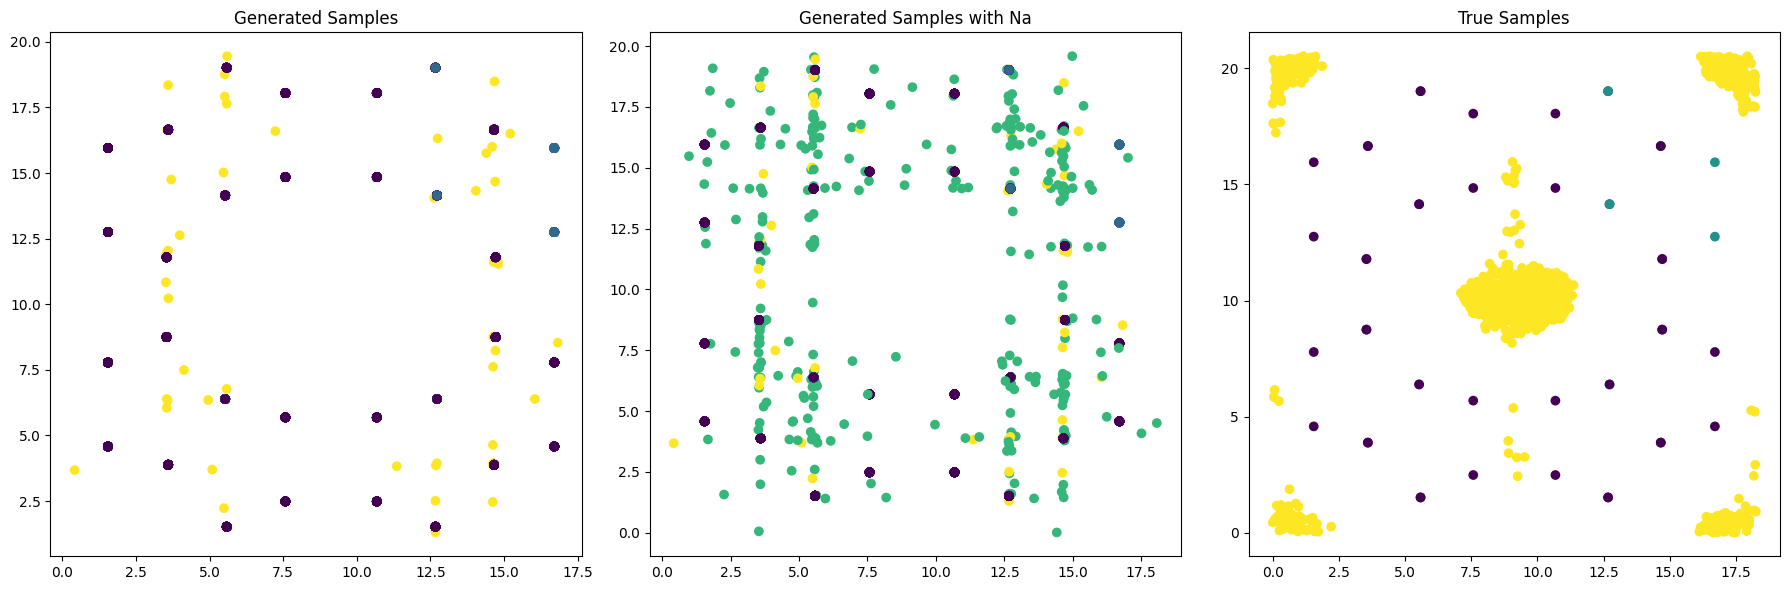

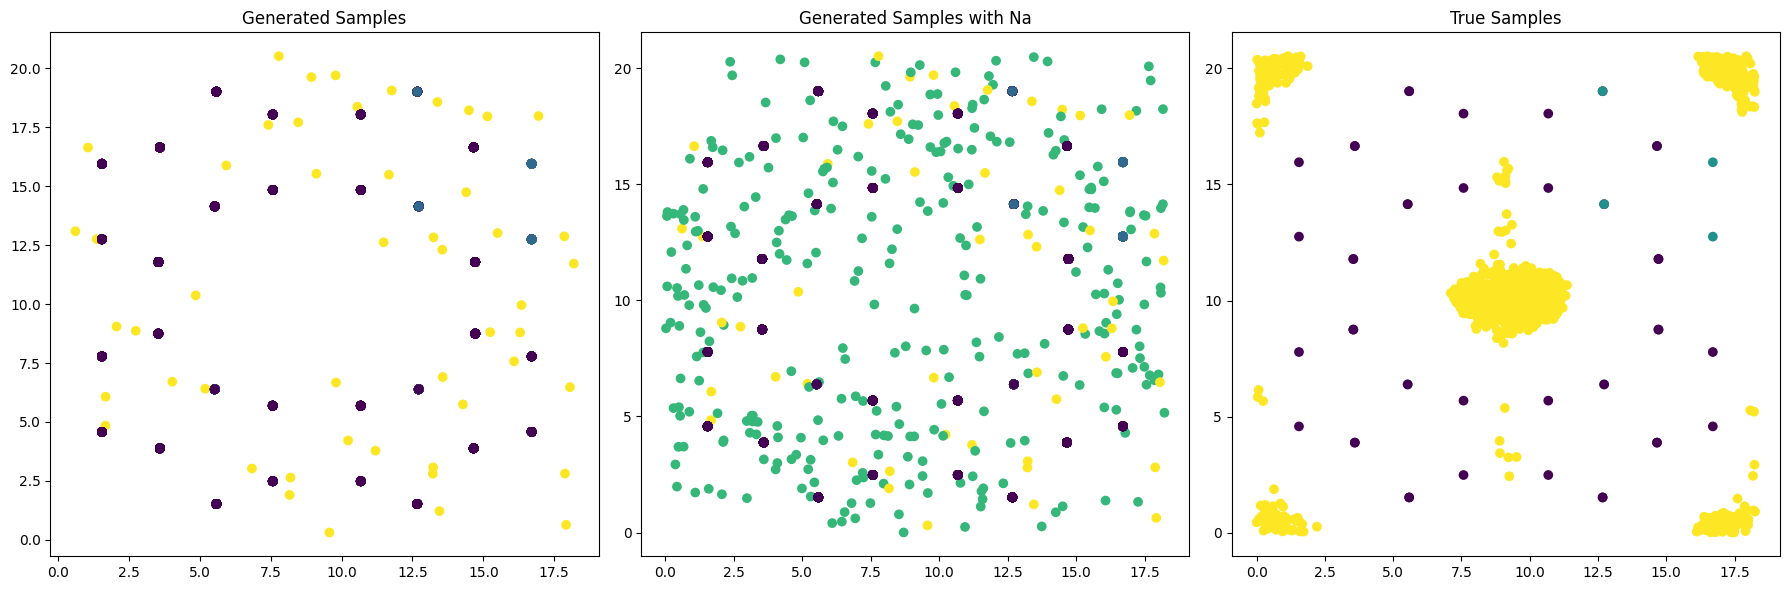

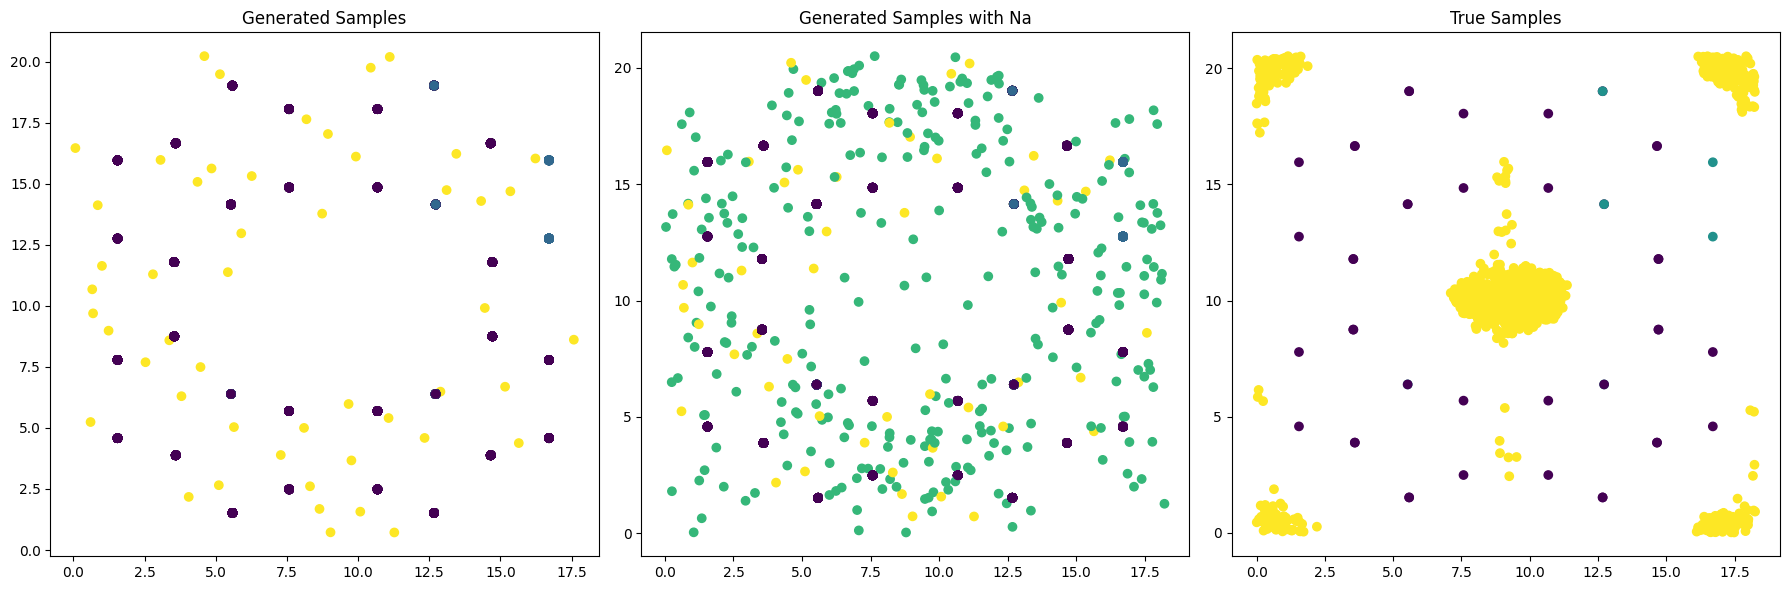

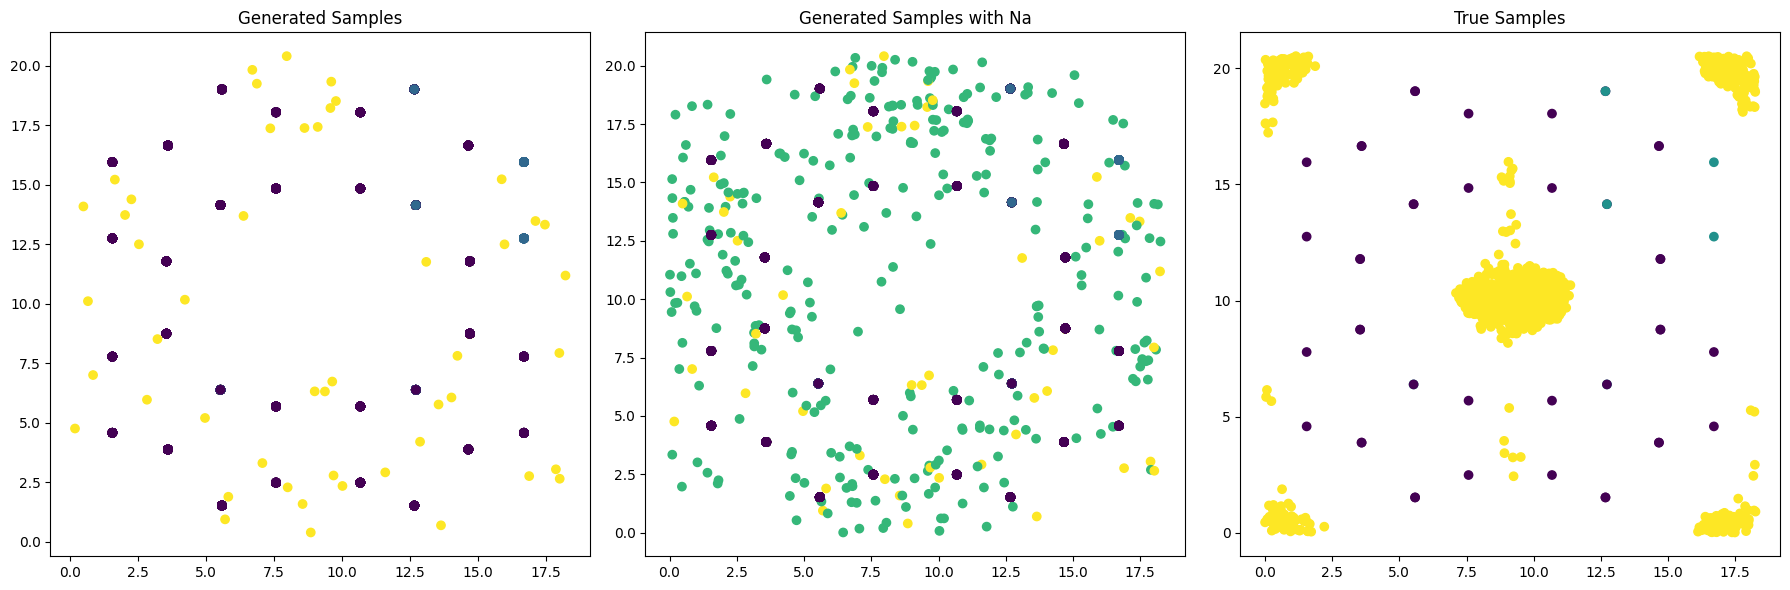

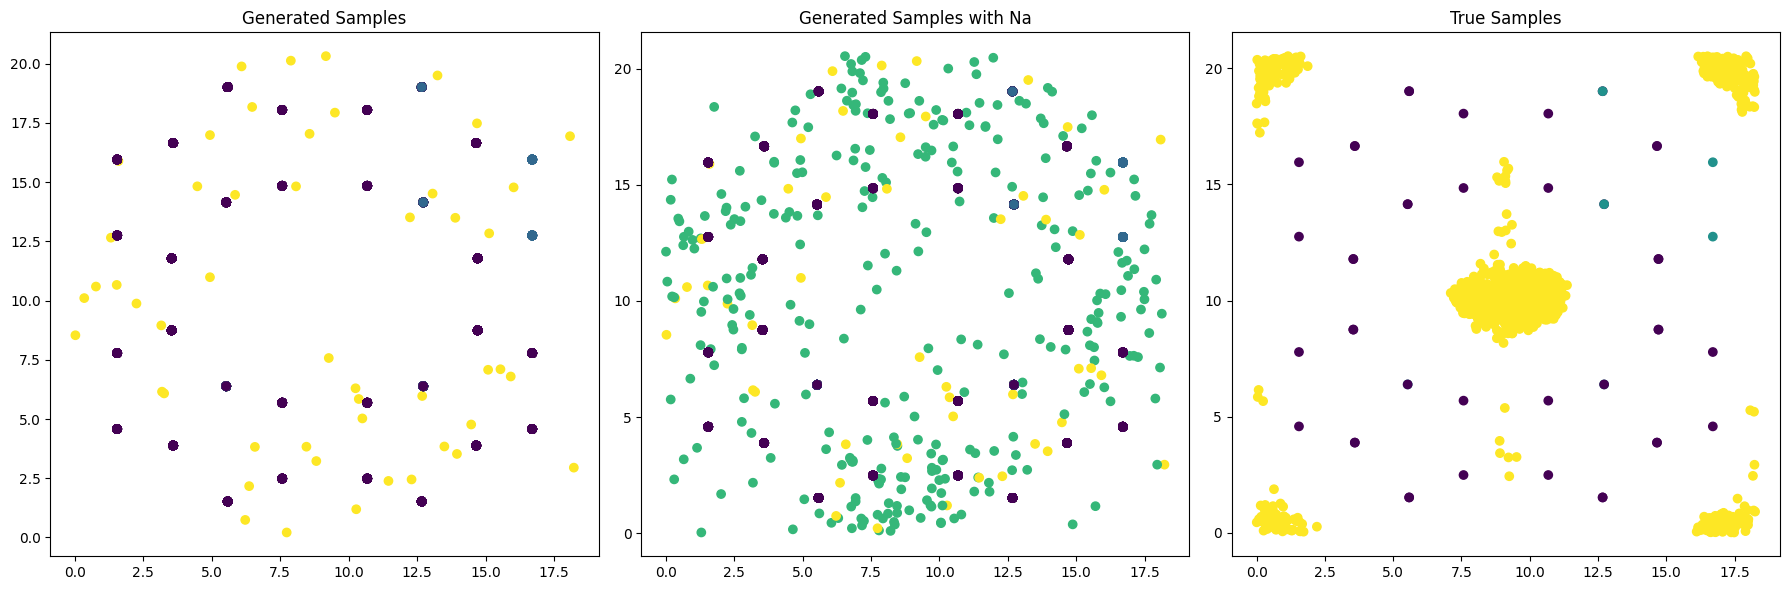

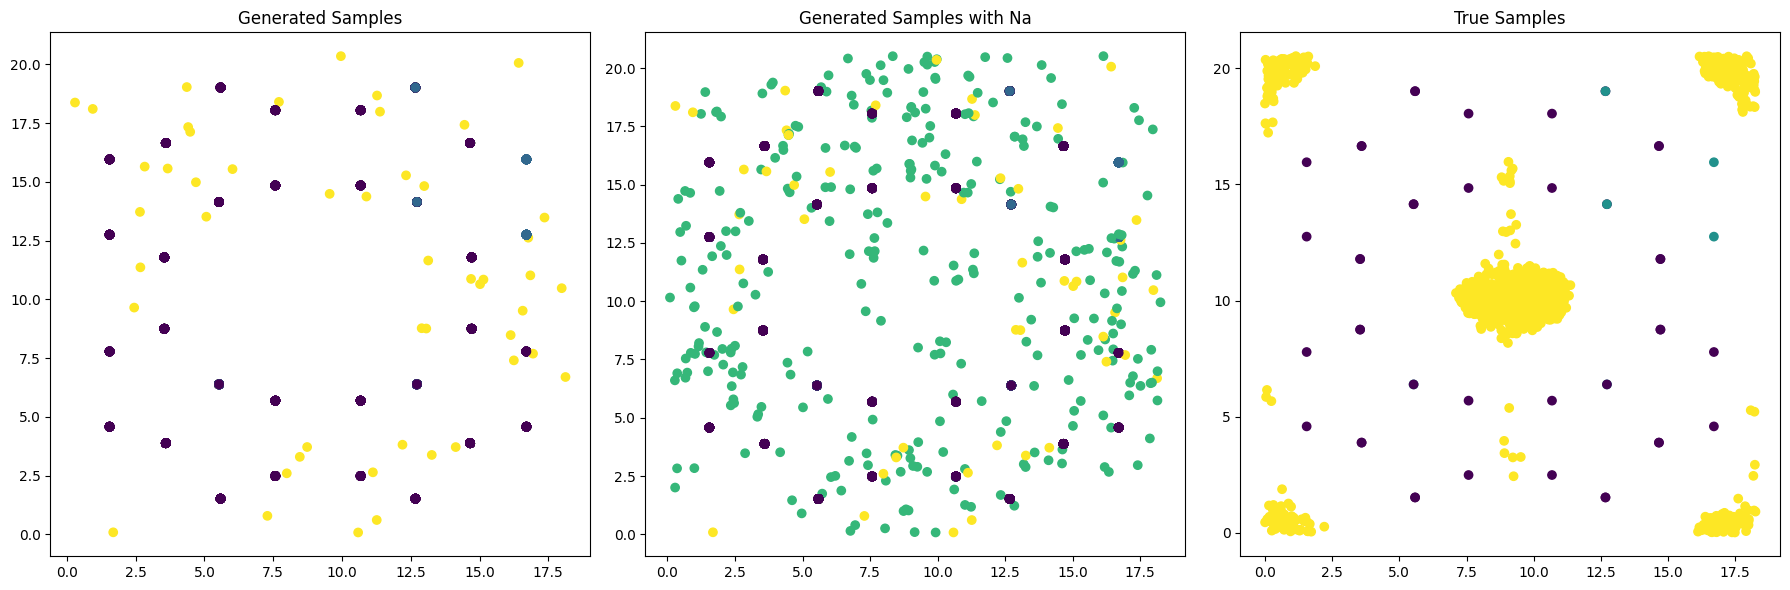

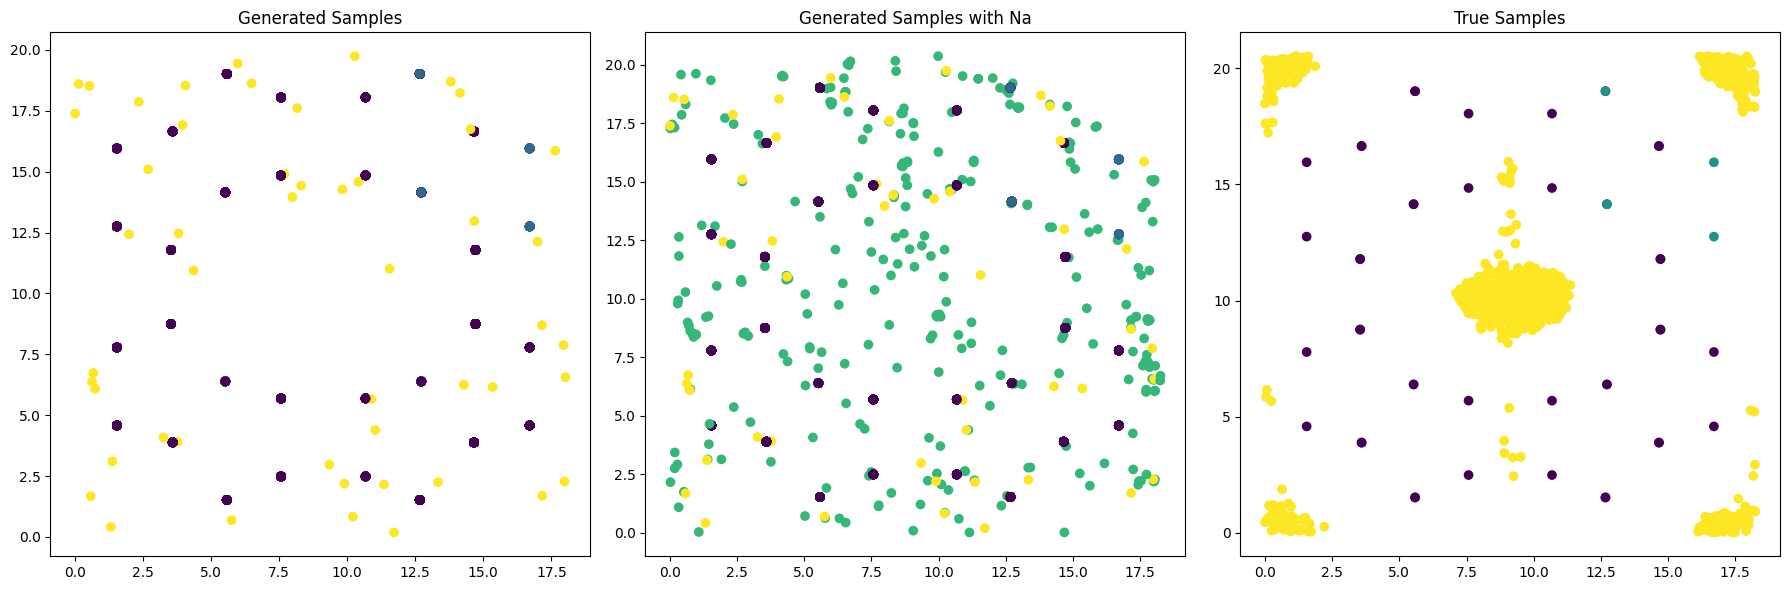

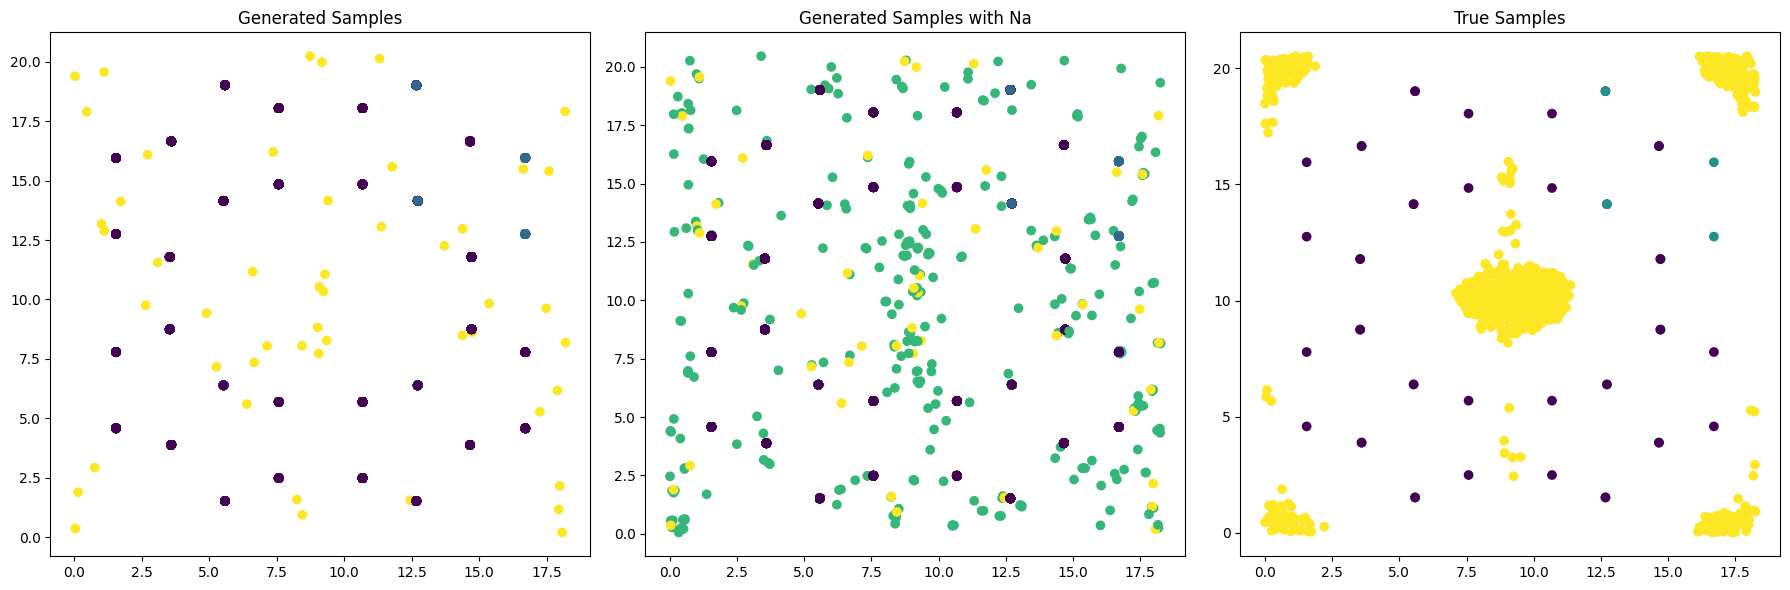

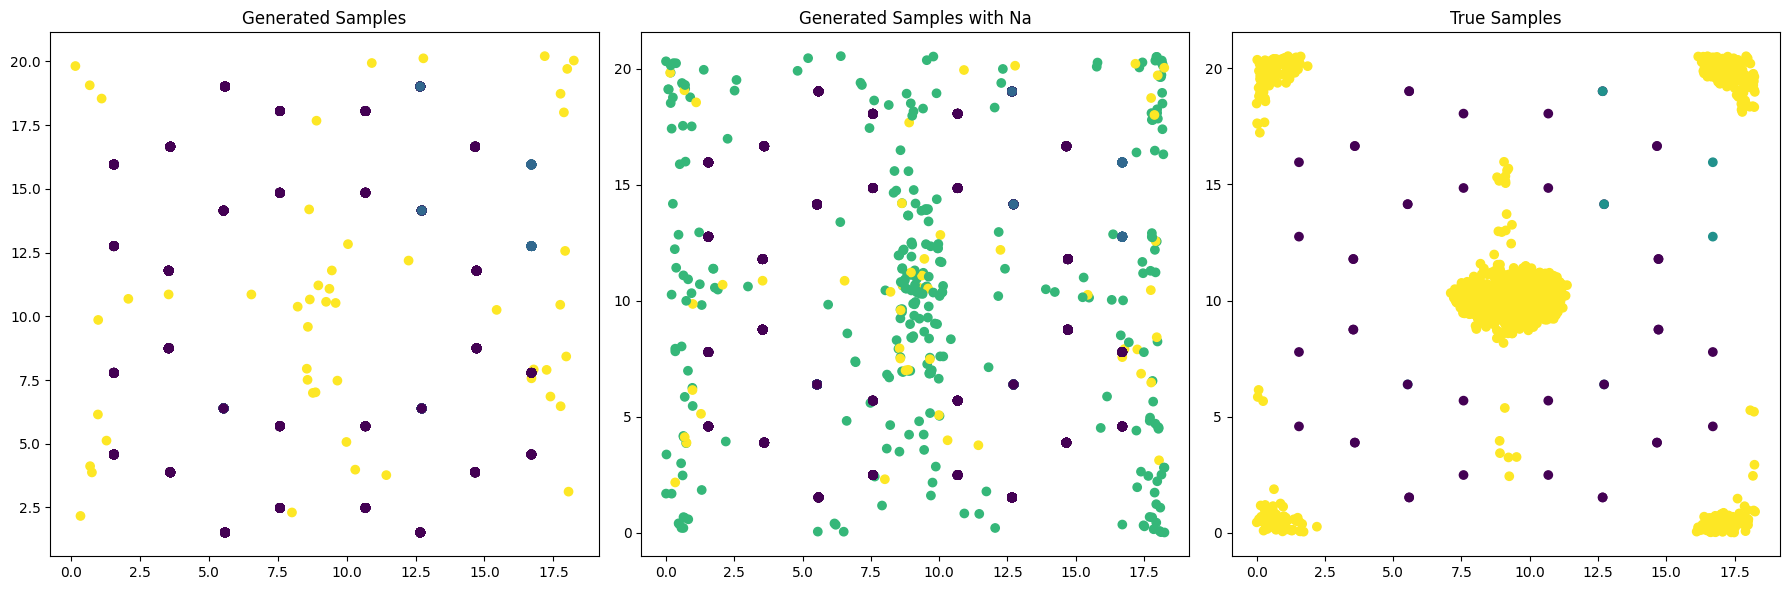

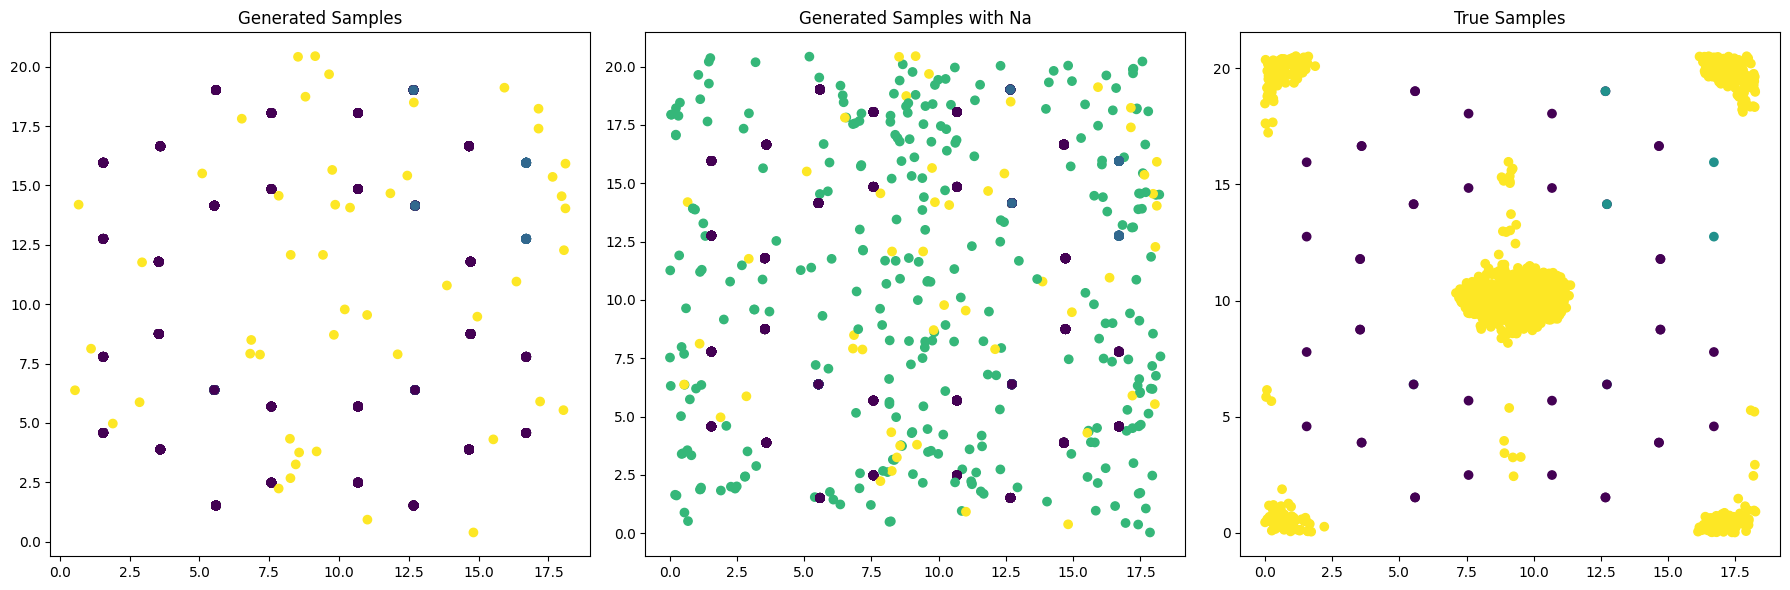

In [53]:
losses = []
for e in range(epoch):
    vae.train()
    n_batches = len(trainloader)
    pbar = tqdm(enumerate(trainloader))
    for idx, databatch in pbar:
        log_dict = vae.training_step(databatch, beta=beta, opt=opt)
        pbar.set_postfix_str(f"loss: {log_dict['loss']:.3f}")
        losses.append(log_dict['loss'])
        step = e*n_batches + idx
        wandb.log(log_dict, step=step)

        if step % 1000 == 0:
            fig, e_true, e_pred = get_sample(1100, ld_kwargs)
            wandb.log({f'sample':wandb.Image(fig)}, step=step)
            wandb.log({'E_true_mu':e_true.mean(), 'E_true_sigma':e_true.std(), 'E_pred_mu':e_pred.mean(), 'E_pred_sigma':e_pred.std()},step=step)

In [ ]:
# losses2 = []
# for e in range(3):
#     vae.train()
#     n_batches = len(trainloader)
#     pbar = tqdm(enumerate(trainloader))
#     for idx, databatch in pbar:
#         log_dict = vae.training_step(databatch, beta=beta, opt=opt)
#         pbar.set_postfix_str(f"loss: {log_dict['loss']:.3f}")
#         losses2.append(log_dict['loss'])
#         step = e*n_batches + idx
#         wandb.log(log_dict, step=step)

#         if step % 1000 == 0:
#             fig = get_sample(1200, ld_kwargs)
#             wandb.log({f'sample':wandb.Image(fig)}, step=step)

In [80]:
zeo_ats = np.zeros((48,), dtype=int)
zeo_ats[[1,12,31]] = 1
_, X  = get_atoms('data/co2_cifs/MOR_1000.cif')

In [81]:
ats, pos, pos_list = vae.sample(zeo_ats, X, 100, ld_kwargs)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:20<00:00,  1.62s/it]


In [82]:
ats.argmax(1) < 2

tensor([ True,  True,  True,  ..., False, False, False], device='cuda:0')

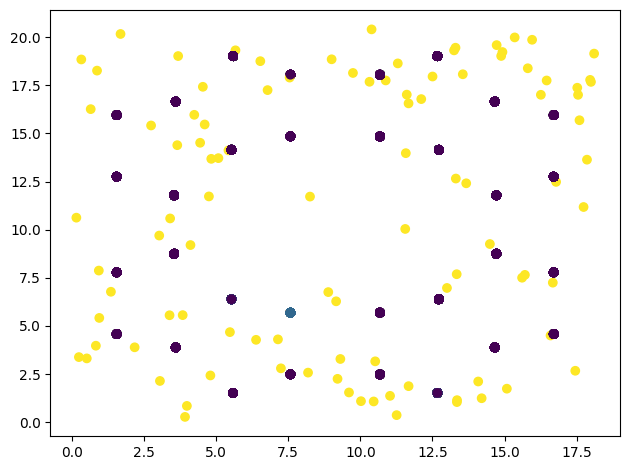

In [100]:
mask = ats.argmax(1) != 2
poss = pos[mask]
atss = ats[mask]

fig, ax = plt.subplots()
ax.scatter(poss[:,0].cpu(), poss[:,1].cpu(), c=atss.argmax(1).cpu())
fig.tight_layout()

(0.0, 10.0)

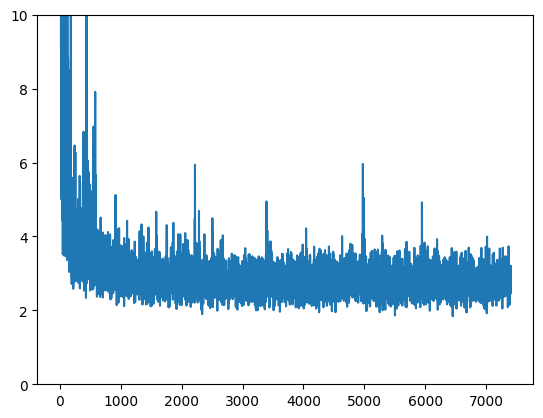

In [86]:
plt.plot(losses)
plt.ylim(0,10)